# Задание на анализ данных

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn import metrics

**Задача:** провести разведочный анализ данных, придумать продуктовые и технические гипотезы — какую ценность можете извлечь из данных для организации, которая предоставила данные.

## EDA

### 1. Загружаю данные

In [55]:
transaction_df = pd.read_parquet('data/transaction_fraud_data.parquet')
exchange_df = pd.read_parquet('data/historical_currency_exchange.parquet')

In [56]:
transaction_df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,is_fraud,last_hour_activity.num_transactions,last_hour_activity.total_amount,last_hour_activity.unique_merchants,last_hour_activity.unique_countries,last_hour_activity.max_single_amount
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,197.153.60.199,False,False,False,False,1197,3.349856e+07,105,12,1.925481e+06
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,208.123.221.203,True,True,False,True,509,2.011476e+07,100,12,5.149117e+06
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,10.194.159.204,False,False,False,False,332,3.916385e+07,97,12,1.852242e+06
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,17.230.177.225,False,False,False,False,764,2.201260e+07,105,12,2.055798e+06
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,136.241.219.151,True,False,False,True,218,4.827636e+06,88,12,1.157231e+06


In [57]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 27 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   transaction_id                        object        
 1   customer_id                           object        
 2   card_number                           int64         
 3   timestamp                             datetime64[us]
 4   vendor_category                       object        
 5   vendor_type                           object        
 6   vendor                                object        
 7   amount                                float64       
 8   currency                              object        
 9   country                               object        
 10  city                                  object        
 11  city_size                             object        
 12  card_type                             object        
 13  is_card_pres

In [58]:
exchange_df.head()

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


In [59]:
exchange_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    31 non-null     datetime64[ns]
 1   AUD     31 non-null     float64       
 2   BRL     31 non-null     float64       
 3   CAD     31 non-null     float64       
 4   EUR     31 non-null     float64       
 5   GBP     31 non-null     float64       
 6   JPY     31 non-null     float64       
 7   MXN     31 non-null     float64       
 8   NGN     31 non-null     float64       
 9   RUB     31 non-null     float64       
 10  SGD     31 non-null     float64       
 11  USD     31 non-null     int64         
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 3.0 KB


### 2. Посмотрю сколько всего уникальных клиентов представлено в датасете 

In [60]:
transaction_df['customer_id'].unique()

array(['CUST_72886', 'CUST_70474', 'CUST_10715', ..., 'CUST_68298',
       'CUST_70840', 'CUST_98321'], shape=(4869,), dtype=object)

### 3. Сколько стран представлено в датасете и как они распределены по транзакциям + доля мошеннических операций по странам (countplot)

In [61]:
transaction_df['country'].unique()

array(['UK', 'Brazil', 'Japan', 'Australia', 'Nigeria', 'Germany',
       'Mexico', 'Russia', 'France', 'Canada', 'Singapore', 'USA'],
      dtype=object)

<Axes: xlabel='country'>

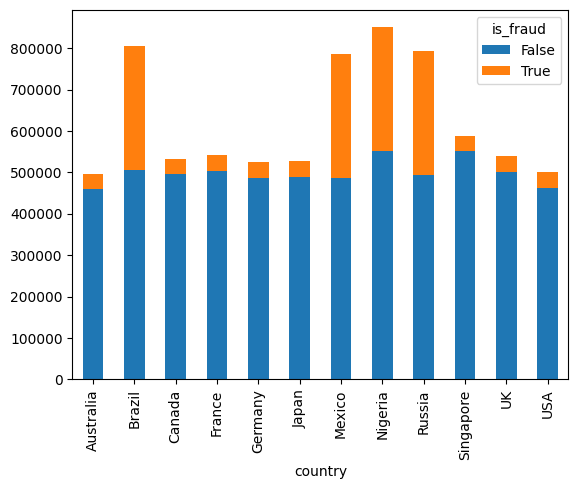

In [62]:
pd.crosstab(transaction_df['country'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

из данных можно увидеть интересное наблюдение, что за рассматриваемый в датасете период число "хороших" транзакций +- одинаковое, в странах с самым высоким числом операций самая высокая доля мошеннических транзакций, отсюда возникает **гипотеза**, что "нормальные" операции происходят с какой то постоянной частотностью, а при мошеннических операциях, увеличивается частотность транзакций

### 4. За какой временной период датасет

In [63]:
print('from', transaction_df['timestamp'].min(), 'to', transaction_df['timestamp'].max())

from 2024-09-30 00:00:01.034820 to 2024-10-30 23:59:59.101885


за месяц

### 5. Теперь глянем как транзакции распределены под дням (и разделение мошеннических - не мошеннических)

In [64]:
transaction_df['date'] = transaction_df['timestamp'].dt.date

<Axes: xlabel='date'>

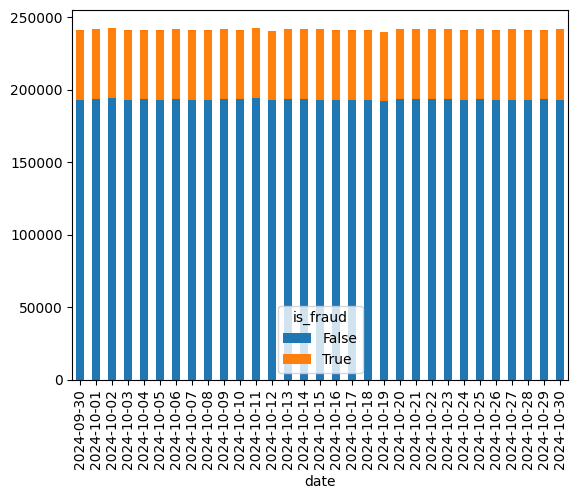

In [65]:
pd.crosstab(transaction_df['date'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

распределение транзакций по дням почти равномерное + доля мошеннических транзакций по дням не меняется

### 6. Посмотрим на `last_hour_activity.num_transactions`

<Axes: >

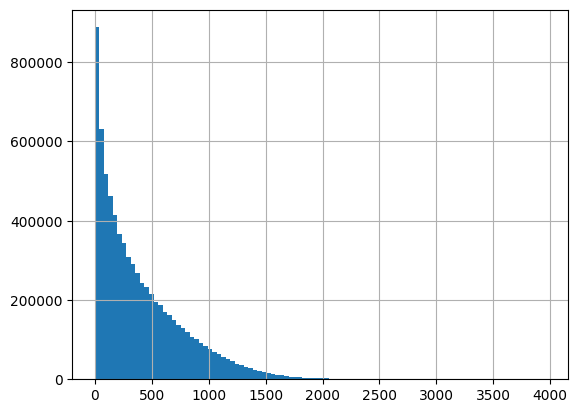

In [66]:
transaction_df['last_hour_activity.num_transactions'].hist(bins=100)

посмотрим на раздельной распределение мошеннических и "хороших" транзакций

<Axes: xlabel='last_hour_activity.num_transactions', ylabel='Count'>

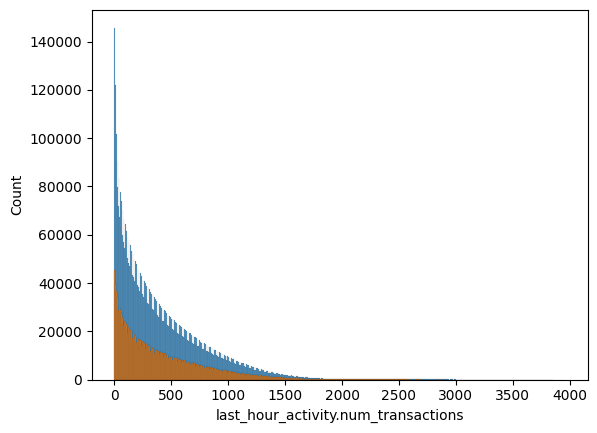

In [67]:
sns.histplot(data=transaction_df[transaction_df['is_fraud'] == False]['last_hour_activity.num_transactions'], label='good')
sns.histplot(data=transaction_df[transaction_df['is_fraud'] == True]['last_hour_activity.num_transactions'], label='fraud')

ниже та же гистограмма, но теперь беру 10к случайных семплов с каждой группы, чтобы не был эффект несбалансированности 2х классов

<Axes: xlabel='last_hour_activity.num_transactions', ylabel='Count'>

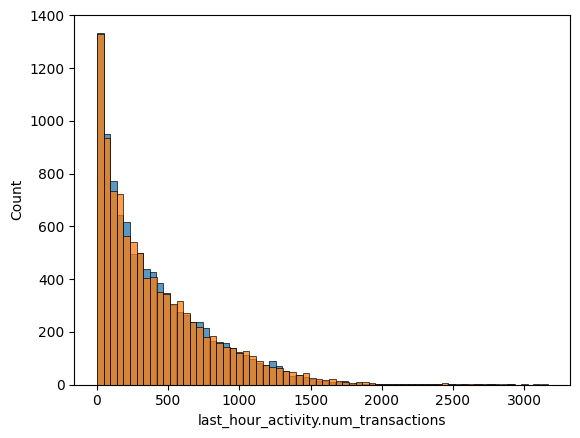

In [68]:
sns.histplot(data=transaction_df[transaction_df['is_fraud'] == False].sample(10000)['last_hour_activity.num_transactions'], label='good')
sns.histplot(data=transaction_df[transaction_df['is_fraud'] == True].sample(10000)['last_hour_activity.num_transactions'], label='fraud')

так как распределения похожи на экспоненциальные, можем глянуть на их параметр лямбда

In [69]:
print('lambda_good', 1 / transaction_df[transaction_df['is_fraud'] == False]['last_hour_activity.num_transactions'].mean())
print('lambda_fraud', 1 / transaction_df[transaction_df['is_fraud'] == True]['last_hour_activity.num_transactions'].mean())

lambda_good 0.002449404290022653
lambda_fraud 0.0024232409401746657


как то увидеть что по этому признаку можно выделить мошеннические операции, не удалось

### 7. При работе с денежными значениями имеет смысл привести всё к одной валюте, в нашем случае удобнее всего все будет привести к доллару.

In [70]:
exchange_df['date'] = exchange_df['date'].dt.date
transaction_df = transaction_df.merge(exchange_df, how='left', on=['date'])

transaction_df['usd_amount'] = 0.0
transaction_df['last_hour_activity.usd_total_amount'] = 0.0

In [71]:
transaction_df['currency'].unique()

array(['GBP', 'BRL', 'JPY', 'AUD', 'NGN', 'EUR', 'MXN', 'RUB', 'CAD',
       'SGD', 'USD'], dtype=object)

In [72]:
for curr in tqdm(transaction_df['currency'].unique()):
    mask = transaction_df['currency'] == curr
    transaction_df.loc[mask, 'usd_amount'] = transaction_df.loc[mask, 'amount'] / transaction_df.loc[mask, curr]
    transaction_df.loc[mask, 'last_hour_activity.usd_total_amount'] = transaction_df.loc[mask, 'last_hour_activity.total_amount'] / transaction_df.loc[mask, curr]

100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


### 8. Посмотрим на распределение сумм транзакций по странам

<Axes: >

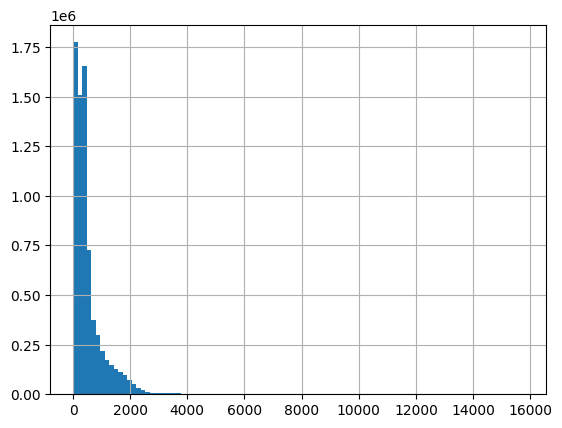

In [73]:
transaction_df['usd_amount'].hist(bins=100)

экспоненциальное распределение, поэтому посмотрим на log1p

<Axes: ylabel='log_usd_amount'>

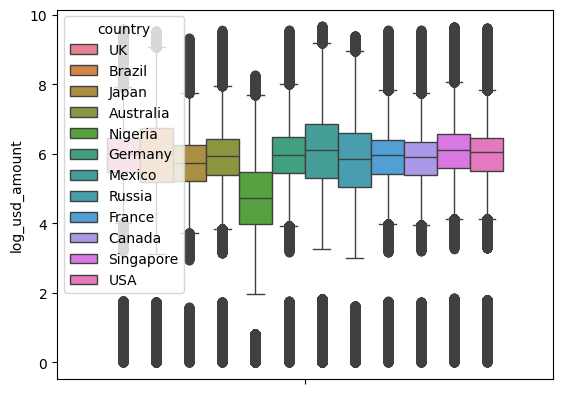

In [74]:
transaction_df['log_usd_amount'] = np.log1p(transaction_df['usd_amount'])
sns.boxplot(data=transaction_df, y='log_usd_amount', hue='country')

из за эксопненциальности, таким образом сравнивать исходные распределения невозможно, в логарифме видно смешение влево только у Нигерии.

### 9. Посмотрим на типы карт

<Axes: xlabel='card_type'>

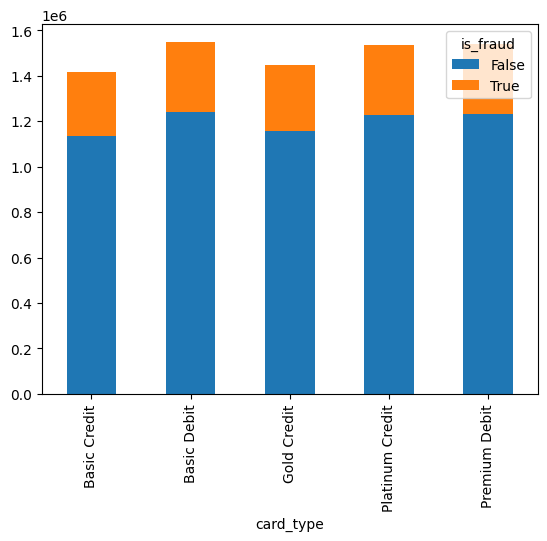

In [75]:
pd.crosstab(transaction_df['card_type'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

### 10. Посмотрим на `is_outside_home_country`

<Axes: xlabel='is_outside_home_country'>

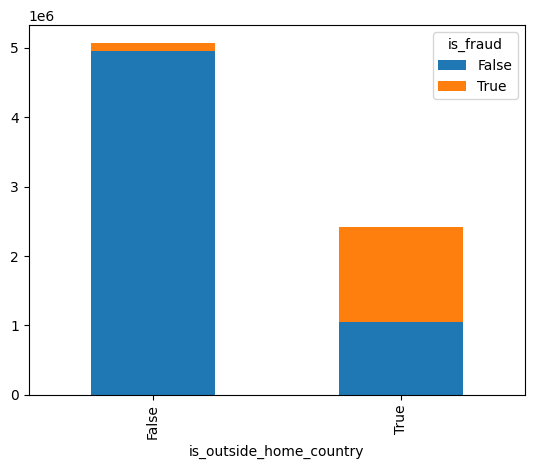

In [76]:
pd.crosstab(transaction_df['is_outside_home_country'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

видно, что этот признак очень сильный. В то время как доля мошенинческих операций среди транзакций внутри homeland очень мала, эта доля за пределами homeland очень высокая. На основе этого результата есть две гипотезы, которые хочется проверить. Первая гипотеза, что транзакции с положительным `is_outside_home_country` и высокой суммой транзакции дают высокий риск мошенничества. Вторая гипотеза, что существуют категории или типы вендоров, для которых транзакции с `is_outside_home_country` это ок.

### 11. Посмотрим на типы и категории вендоров

<Axes: xlabel='vendor_type'>

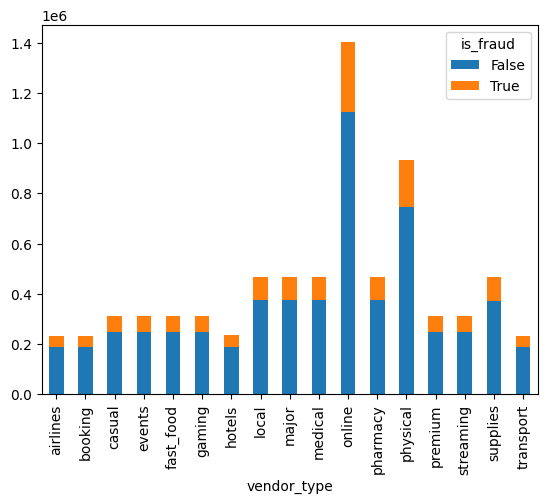

In [77]:
pd.crosstab(transaction_df['vendor_type'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

<Axes: xlabel='vendor_category'>

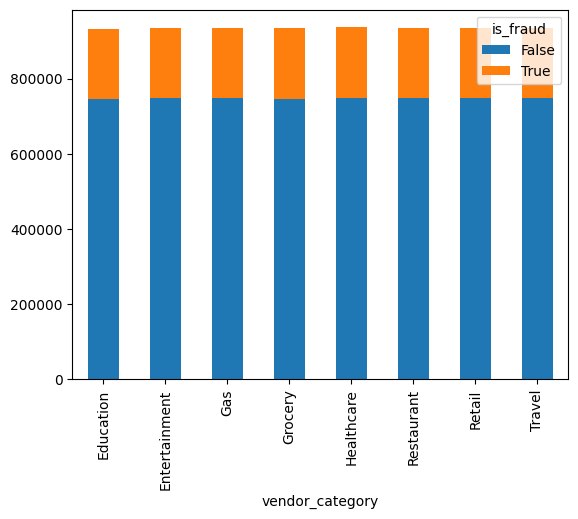

In [78]:
pd.crosstab(transaction_df['vendor_category'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

### 12. Посмотрим на наименования вендоров

In [79]:
transaction_df['vendor'].unique()

array(['Taco Bell', 'Steam', 'Whole Foods', 'Exxon', 'Medical Center',
       'Coursera', 'Instacart', 'Westin', 'eBay', 'DuaneReade', 'Nobu',
       'FreshDirect', 'StubHub', 'University Bookstore',
       'American Airlines', 'Home Depot', "Morton's", 'Ticketmaster',
       'Skillshare', 'Local Gas Station', 'Texaco', 'Hotels.com',
       'Walmart Grocery', 'Epic Games', 'AMC Theaters', 'Etsy', 'IKEA',
       'Costco', 'Spotify', 'Capital Grille', "Trader Joe's",
       'Urgent Care', 'Careem', "Wendy's", "Macy's", 'Udemy', 'Target',
       'Truck Stop', 'BP', 'TGI Fridays', 'Chevron', 'Amazon', 'Newegg',
       'Nike Store', 'Amazon Prime', 'Aldi', 'MasterClass', 'Burger King',
       'Airbnb', 'Xbox Live', 'Red Lobster', 'Highway Gas Stop',
       'Walmart', 'LiveNation', 'KFC', 'Mobil', 'Wayfair', "Applebee's",
       'Chegg', 'Lyft', 'JetBlue', 'Netflix', 'Publix', 'Amazon Fresh',
       'CVS Pharmacy', 'Uber', 'Disney+', 'PlayStation Store', 'edX',
       'AliExpress', 'Local Ho

посмотрим на доли мошеннических операций для каждого вендора за весь период датасета

In [80]:
transaction_df[['vendor', 'is_fraud']].groupby('vendor').mean().reset_index().sort_values(by='is_fraud')

,vendor,is_fraud
100,Westin,0.196302
34,HBO Max,0.196544
23,Delta,0.196892
43,IKEA,0.197129
4,Amazon,0.197431
...,...,...
45,JetBlue,0.202471
81,StubHub,0.202724
68,Publix,0.203279
90,Uber,0.203362


С вендорами хочется проверить следующую гипотезу: Если за последний промежуток времени (можно взять 12 часов) доля мошеннических операций с этим вендором была высокая, то риск что следующая операция будет мошеннической - высокий.

### 13. Изучим признаки связанные с устройство, через которое осуществлялась транзакция

In [81]:
transaction_df.shape

(7483766, 42)

<Axes: xlabel='device'>

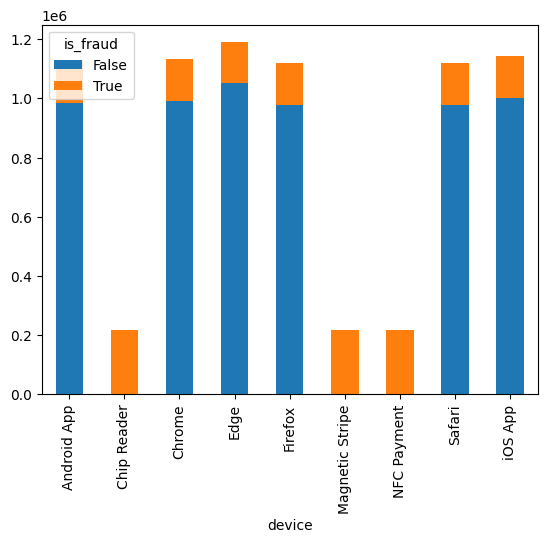

In [82]:
pd.crosstab(transaction_df['device'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

In [83]:
transaction_df[transaction_df['device'] == 'Chip Reader']['is_fraud'].value_counts()

is_fraud
True    217324
Name: count, dtype: int64

в то время как у всех девайсов +- одинаковое соотношение транзакций. все транзакции при Chip Reader, Magnetic Stripe, NFC Payment отмечены мошеннические. Скорее всего какая то ошибка в данных, потому что скорее всего эти транзакции относятся к оплате через терминал

<Axes: xlabel='channel'>

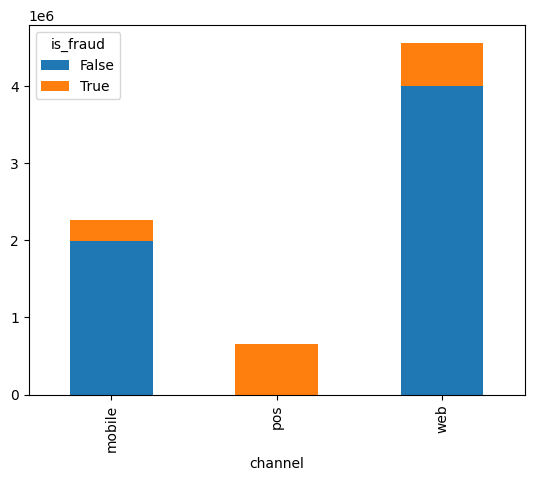

In [84]:
pd.crosstab(transaction_df['channel'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

опять же, все транзакции через терминал, помечены как мошеннические почему то (аналогичная история выше)

<Axes: xlabel='is_card_present'>

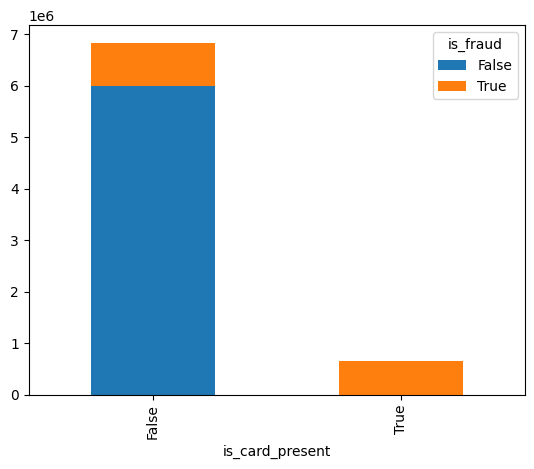

In [85]:
pd.crosstab(transaction_df['is_card_present'], transaction_df['is_fraud']).plot(kind='bar', stacked=True)

### 14. Device fingerprint

Уберем POS признаки и посмотрим сколько в среднем устройств приходится на одного клиента

<Axes: >

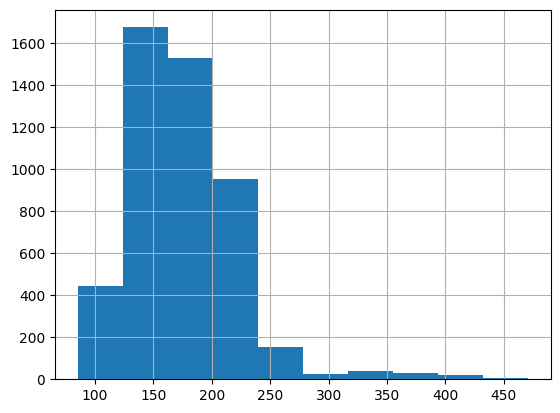

In [89]:
transaction_df[transaction_df['channel'] != 'pos'][['customer_id', 'device_fingerprint']].groupby('customer_id').nunique()['device_fingerprint'].hist()

Последняя гипотеза, которую буду проверять - что чем реже устройство встречалось в транзакциях у этого клиента, тем выше риск что операция мошенническая

## Проверка гипотез

### Гипотеза 1

>"нормальные" операции происходят с какой то постоянной частотностью, а при мошеннических операциях, увеличивается частотность транзакций

Хотя EDA показало, что общее распределение `last_hour_activity.num_transactions` при мошеннических и хороших результатах не дало результата, здесь мы посмотрим на этот признак в разбиении по клиентам. Для проверки гипотезы, я буду смотреть на то как у юзеров изменяются число транзакций за последний час относительного медианного значения, и сопоставим для "хороших" операций.

выберем тех пользователей, для которых есть как хорошие так и мошеннические операции:

In [28]:
good_t_users = transaction_df[transaction_df['is_fraud'] == True]['customer_id'].unique()
fraud_t_users = transaction_df[transaction_df['is_fraud'] == False]['customer_id'].unique()
both_users = np.intersect1d(good_t_users, fraud_t_users)
both_users

array(['CUST_10000', 'CUST_10018', 'CUST_10022', ..., 'CUST_99952',
       'CUST_99957', 'CUST_99971'], shape=(4869,), dtype=object)

In [29]:
avg_df = transaction_df[transaction_df['customer_id'].isin(both_users)][['customer_id', 'last_hour_activity.num_transactions']].groupby(
    'customer_id').median().reset_index()
avg_df = avg_df.rename(columns={'last_hour_activity.num_transactions': 'median_last_hour_activity.num_transactions'})

In [30]:
trunc_df = transaction_df[transaction_df['customer_id'].isin(both_users)]
trunc_df = trunc_df.merge(avg_df, how='left', on='customer_id')

In [31]:
trunc_df['rel_diff'] = (trunc_df['last_hour_activity.num_transactions'] - trunc_df['median_last_hour_activity.num_transactions']) / (trunc_df['median_last_hour_activity.num_transactions'] + 1e-6)

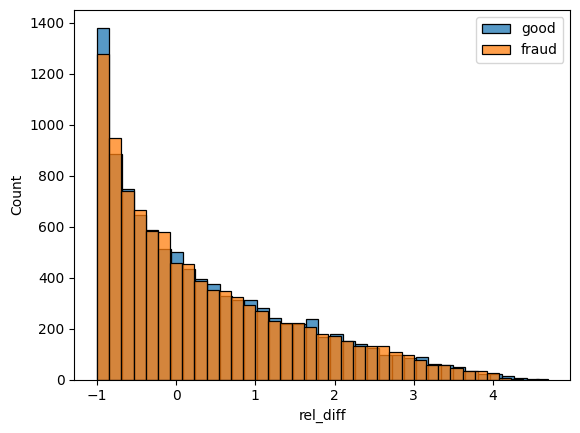

In [32]:
sns.histplot(data=trunc_df[trunc_df['is_fraud'] == False].sample(10000)['rel_diff'], label='good')
sns.histplot(data=trunc_df[trunc_df['is_fraud'] == True].sample(10000)['rel_diff'], label='fraud')
plt.legend()

разницы в распределениях особой нет, поэтому подтвердить гипотезу не удалось

### Гипотеза 2

> Транзакции с положительным `is_outside_home_country` и высокой суммой транзакции дают высокий риск мошенничества.

Для исследования этой гипотезы построим ROC кривую, где возьмем транзакции `is_outside_home_country` и будем считать TPR, FPR относительно `is_fraud`, а порог перебирать по `amount`

In [33]:
transaction_df['is_fraud']

0          False
1           True
2          False
3          False
4           True
           ...  
7483761    False
7483762    False
7483763    False
7483764    False
7483765    False
Name: is_fraud, Length: 7483766, dtype: bool

Text(0, 0.5, 'TPR')

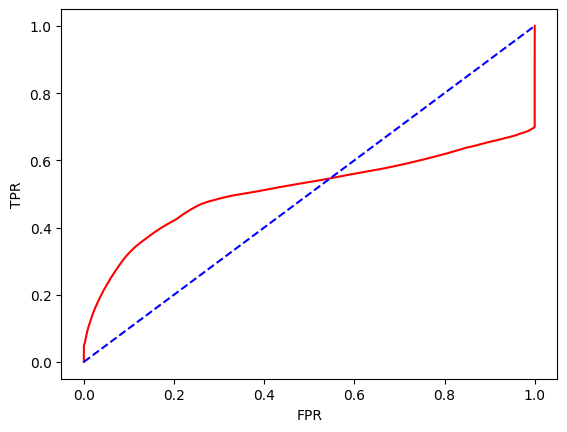

In [34]:
mask = transaction_df['is_outside_home_country'] == True
fpr, tpr, t = metrics.roc_curve(
    transaction_df[mask]['is_fraud'],
    transaction_df[mask]['usd_amount'],
    pos_label=True
)
plt.plot(fpr, tpr, color='red')
plt.plot(
    np.linspace(0, 1.0, num=10, endpoint=True), np.linspace(0, 1.0, num=10, endpoint=True),
    color='blue', ls='--'
)
plt.xlabel('FPR')
plt.ylabel('TPR')

посмотрим какие пороги лежат в области TPR от 0 до 0.5:

Text(0, 0.5, 'THRESHOLD')

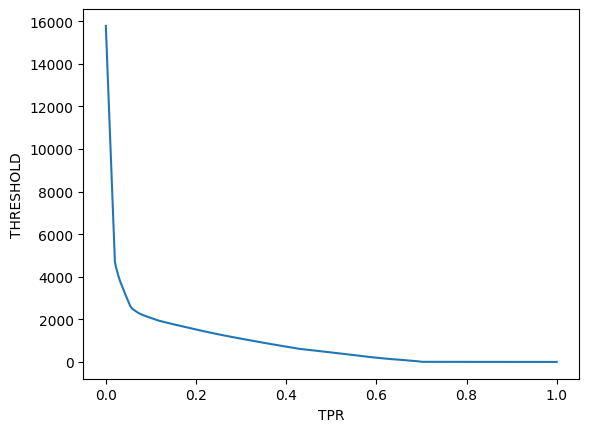

In [35]:
plt.plot(tpr, t)
plt.xlabel('TPR')
plt.ylabel('THRESHOLD')

анализируя результаты РОК кривой, можем заметить, что при больших значениях порога `usd_amount`(где то от 1000). Разделение по `usd_amount` среди `is_outside_home_country` == True транзакций дает неплохой прирост относительно случайного угадывания. Посмотрим на распределения

<Axes: xlabel='log_usd_amount'>

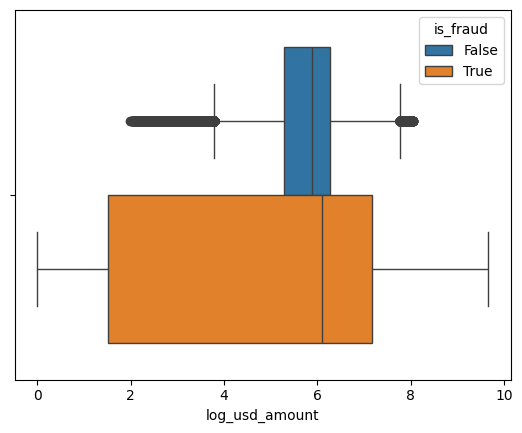

In [36]:
sns.boxplot(data=transaction_df[mask], x='log_usd_amount', hue='is_fraud')

<Axes: xlabel='usd_amount', ylabel='Count'>

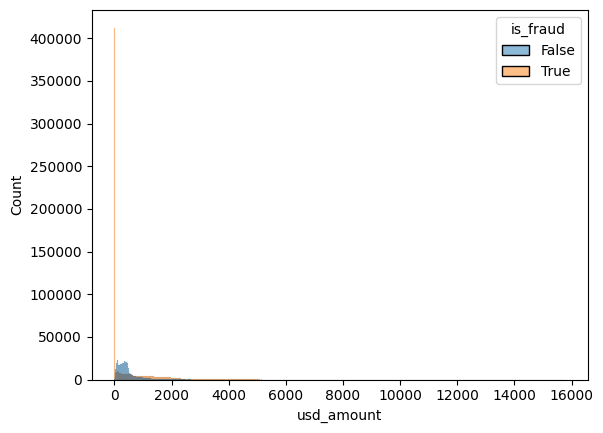

In [37]:
sns.histplot(data=transaction_df[mask], x='usd_amount', hue='is_fraud')

<Axes: xlabel='usd_amount', ylabel='Count'>

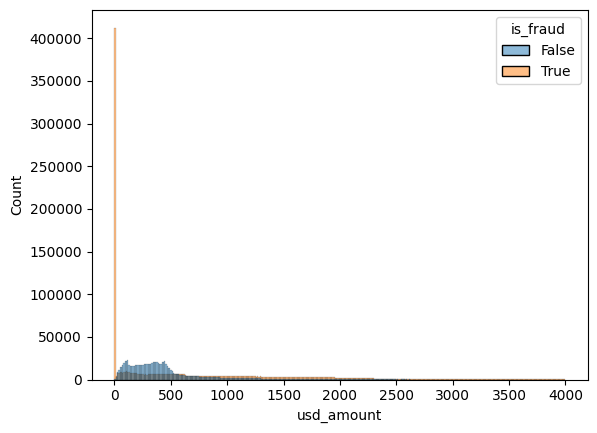

In [38]:
sns.histplot(data=transaction_df[(mask) & (transaction_df['usd_amount'] < 4000)], x='usd_amount', hue='is_fraud')

<Axes: xlabel='usd_amount', ylabel='Count'>

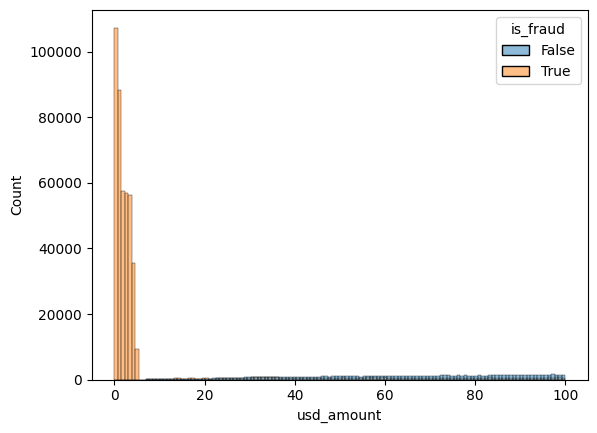

In [39]:
sns.histplot(data=transaction_df[(mask) & (transaction_df['usd_amount'] < 100)], x='usd_amount', hue='is_fraud')

<Axes: xlabel='usd_amount', ylabel='Count'>

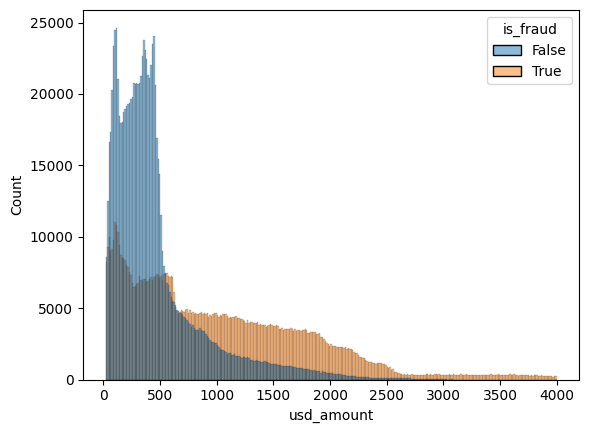

In [40]:
sns.histplot(data=transaction_df[(mask) & (transaction_df['usd_amount'] < 4000) & (transaction_df['usd_amount'] > 20)], x='usd_amount', hue='is_fraud')

по визуализациям распределений получился похожий результат, но можно сделать даже более детальные выводы:
1. Область нормальных для "зарубежных транзакций" лежит в USD объемах в примерно области от 10 до 500, за этими пределами уже преобладают мошеннические операции.
2. Видно очень большое число моешннических транзакций в области от 0 до 5 примерно.
3. Получаем что комбинация признаков `is_outside_home_country` и `usd_amount` сильная при выявлении моешннических транзакций.

### Гипотеза 3.

> Существуют категории или типы вендоров, для которых транзакции с `is_outside_home_country` это ок

<Axes: xlabel='vendor_type'>

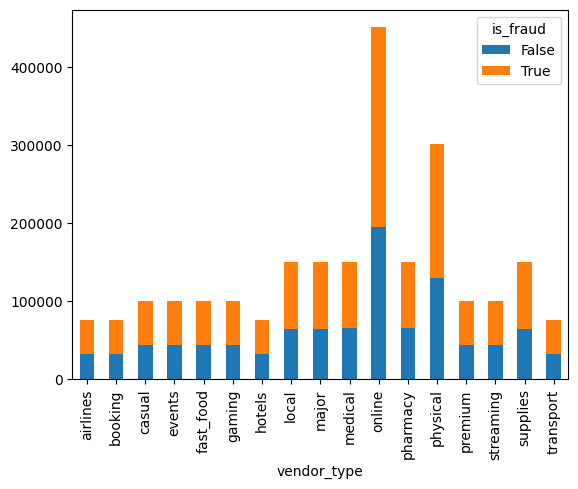

In [41]:
mask = transaction_df['is_outside_home_country'] == True
pd.crosstab(transaction_df[mask]['vendor_type'], transaction_df[mask]['is_fraud']).plot(kind='bar', stacked=True)

<Axes: xlabel='vendor_category'>

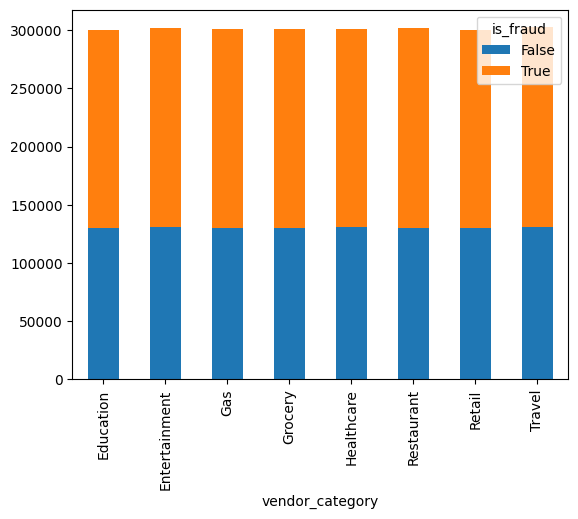

In [42]:
mask = transaction_df['is_outside_home_country'] == True
pd.crosstab(transaction_df[mask]['vendor_category'], transaction_df[mask]['is_fraud']).plot(kind='bar', stacked=True)

Гипотеза не подтвердилась, соотношение хороших и мошеннических транзакций внутри категорий `vendor_type` и `vendor_category` такое же как это соотношение при `is_outside_home_country` == True в целом

### Гипотеза 4

> Если за последний промежуток времени (можно взять 6 часов) доля мошеннических операций с этим вендором была высокая, то риск что следующая операция будет мошеннической - высокий.

In [43]:
transaction_df['seconds'] = transaction_df['timestamp'].dt.floor('s')
per_hour_stats = transaction_df[['seconds', 'vendor', 'is_fraud']].groupby(
    ['seconds', 'vendor']).agg(['count', 'mean']).reset_index()
per_hour_stats.columns = ['_'.join(col).rstrip('_') for col in per_hour_stats.columns.values]
per_hour_stats = per_hour_stats.sort_values(by=['vendor', 'seconds'])
per_hour_stats['is_fraud_mean'] = per_hour_stats['is_fraud_mean'] / per_hour_stats['is_fraud_count']

In [ ]:
# Тут считаю с нуля per_hour_stats
# # def get_prev_12h_mean(group):
# #     means = []
# #     for idx, row in tqdm(group.iterrows(), total=len(group)):
# #         mask = (group['seconds'] < row['seconds']) & (group['seconds'] >= row['seconds'] - pd.Timedelta(hours=12))
# #         prev_12h = group.loc[mask, 'is_fraud_mean']
# #         means.append(prev_12h.mean() if not prev_12h.empty else None)
# #     return means

# def get_prev_6h_mean(group):
#     means = []
#     for idx, row in tqdm(group.iterrows(), total=len(group)):
#         mask = (group['seconds'] < row['seconds']) & (group['seconds'] >= row['seconds'] - pd.Timedelta(hours=6))
#         prev_12h = group.loc[mask, 'is_fraud_mean']
#         means.append(prev_12h.mean() if not prev_12h.empty else None)
#     return means

# # def get_prev_1h_mean(group):
# #     means = []
# #     for idx, row in tqdm(group.iterrows()):
# #         mask = (group['seconds'] < row['seconds']) & (group['seconds'] >= row['seconds'] - pd.Timedelta(hours=1))
# #         prev_12h = group.loc[mask, 'is_fraud_mean']
# #         means.append(prev_12h.mean() if not prev_12h.empty else None)
# #     return means

# per_hour_stats['last6h_mean'] = (
#     per_hour_stats.groupby('vendor', group_keys=False)
#       .apply(get_prev_6h_mean)
#       .explode()
#       .astype(float)
#       .reset_index(drop=True)
# )
# per_hour_stats.to_parquet('data/per_hour_stats.parquet')

In [45]:
per_hour_stats = pd.read_parquet('data/per_hour_stats.parquet')

In [46]:
per_hour_stats.head()

,seconds,vendor,is_fraud_count,is_fraud_mean,last6h_mean
index,,,,,
26,2024-09-30 00:00:25,AMC Theaters,1,0.0,0.423077
67,2024-09-30 00:00:59,AMC Theaters,1,1.0,0.477612
168,2024-09-30 00:02:00,AMC Theaters,1,0.0,0.572917
197,2024-09-30 00:02:20,AMC Theaters,1,0.0,0.574873
291,2024-09-30 00:03:30,AMC Theaters,1,1.0,0.598797


теперь законнектим  эти данные к общему датафрейму

In [47]:
per_hour_stats['seconds'] = per_hour_stats['seconds'] + pd.Timedelta(seconds=1)
transaction_df = transaction_df.merge(per_hour_stats[['seconds', 'last6h_mean']], how='left')

посмотрим на распределение этих средних относительно переменной `is_fraud`

<Axes: xlabel='last6h_mean', ylabel='Count'>

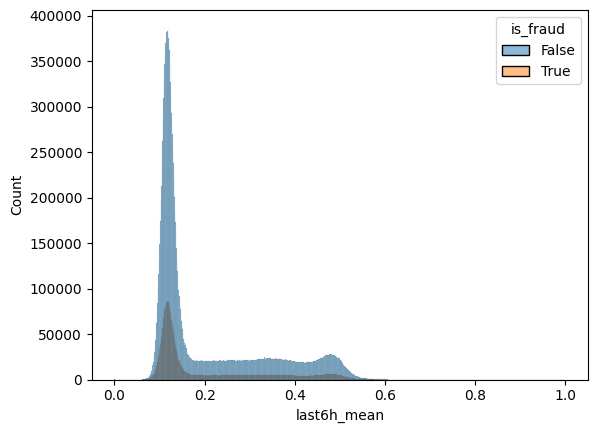

In [49]:
sns.histplot(data=transaction_df, x='last6h_mean', hue='is_fraud')

<Axes: xlabel='last6h_mean'>

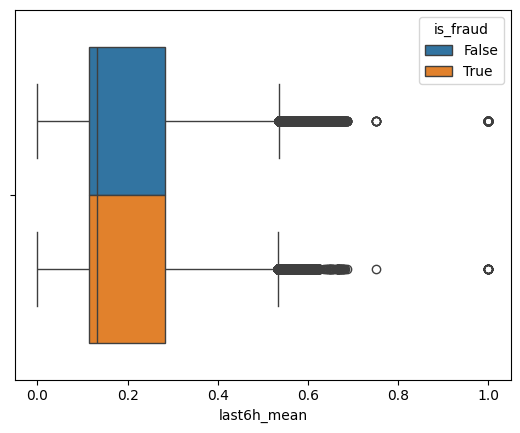

In [50]:
sns.boxplot(data=transaction_df, x='last6h_mean', hue='is_fraud')

Распределения очень похожие, поэтому при контексте 6 часов гипотезу подтвердить не удалось. Вообще признак интересный, возможно что то более интересное могло бы получится, если брать меньший контекст.

### Гипотеза 5

> Чем реже устройство встречалось в транзакциях у этого клиента, тем выше риск что операция мошенническая

для проверки этой гипотезы, чтобы не ждать долго, как в гипотезе 4, я разобью выборку на две части. посчитаю статистики на первой, а работу этих статистик проверю на другой.

In [145]:
train_trans_df = transaction_df[(transaction_df['channel'] != 'pos') & (transaction_df['timestamp'] <= '2024-10-23')]
val_trans_df = transaction_df[(transaction_df['channel'] != 'pos') & (transaction_df['timestamp'] > '2024-10-23')]

посчитаем искомую статистику - частота встречаемости конкретного уникального устройства у конкретного клиента

In [146]:
total_unique_devices = train_trans_df[['customer_id', 'device_fingerprint']].groupby('customer_id').count().reset_index()
total_unique_devices = total_unique_devices.rename(columns={'device_fingerprint': 'unique_device_fingerprint'})
total_unique_devices.head()

,customer_id,unique_device_fingerprint
0,CUST_10000,1066
1,CUST_10018,868
2,CUST_10022,1266
3,CUST_10039,1067
4,CUST_10102,1232


In [147]:
customer_device = train_trans_df[['customer_id', 'device_fingerprint', 'transaction_id']].groupby(['customer_id', 'device_fingerprint']).count().reset_index()
customer_device.head()

,customer_id,device_fingerprint,transaction_id
0,CUST_10000,010a9e3a2f1c757af2c104e0a8956a1d,1
1,CUST_10000,013b7fade83b5085e7dfba59566f0d66,1
2,CUST_10000,04c1879c1832c12b11042d57b8b56bdb,1
3,CUST_10000,07a005eba044fefa130d9fdecf51563d,1
4,CUST_10000,08fba01be4caab186759fee8aceab526,1


In [148]:
customer_device.shape

(635343, 3)

In [149]:
customer_device['transaction_id'].value_counts()

transaction_id
1       625329
315         49
360         47
312         47
346         46
         ...  
697          1
635          1
917          1
1199         1
658          1
Name: count, Length: 1002, dtype: int64

In [150]:
customer_device = customer_device.merge(total_unique_devices, how='left', on='customer_id')
customer_device['device_freq'] = customer_device['transaction_id'] / customer_device['unique_device_fingerprint']

In [151]:
customer_device.head()

,customer_id,device_fingerprint,transaction_id,unique_device_fingerprint,device_freq
0,CUST_10000,010a9e3a2f1c757af2c104e0a8956a1d,1,1066,0.000938
1,CUST_10000,013b7fade83b5085e7dfba59566f0d66,1,1066,0.000938
2,CUST_10000,04c1879c1832c12b11042d57b8b56bdb,1,1066,0.000938
3,CUST_10000,07a005eba044fefa130d9fdecf51563d,1,1066,0.000938
4,CUST_10000,08fba01be4caab186759fee8aceab526,1,1066,0.000938


In [152]:
val_trans_df = val_trans_df.merge(
    customer_device[['customer_id', 'device_fingerprint', 'device_freq']],
    how='left', on=['customer_id', 'device_fingerprint']
)
val_trans_df['device_freq'] = val_trans_df['device_freq'].fillna(0)

<Axes: xlabel='device_freq', ylabel='Count'>

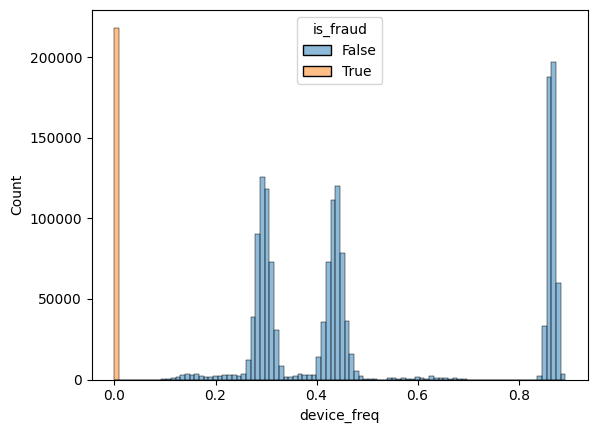

In [154]:
sns.histplot(data=val_trans_df, x='device_freq', hue='is_fraud')

интересные моды при 0.3, 0.5 и 0.9

<Axes: xlabel='device_freq'>

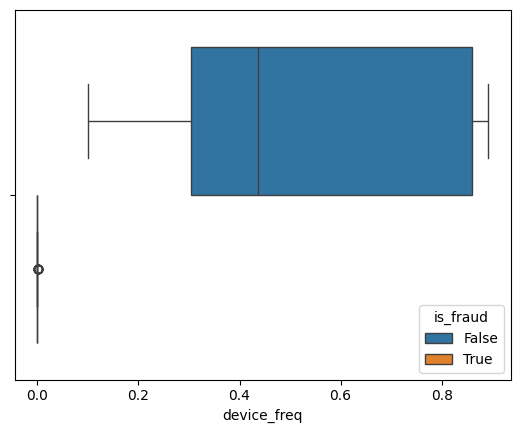

In [155]:
sns.boxplot(data=val_trans_df, x='device_freq', hue='is_fraud')

мы получили, что все новые устройства в транзакциях за последнюю неделю, которых не было в прошлых неделях это мошеннические. гипотеза подтвердилась

## Выводы

1. В данных есть странный артефакт, что все транзакции с оплатой через POS помечены как "мошеннические".
2. Комбинация `is_outside_home_country` вместе с `usd_amount` дает сильный признак, который можно использовать для предиктивной модели.
3. Получилось, что все транзакции, выполненные с новых для клиента уникальных устройст были мошенническими (в последние 7 дней октября). Признак на основе частоты встречаемости устройства у конкретного юзера тоже может использоваться в качестве приззнака для предиктивной модели.
4. Признак "доля мошеннических операций для конкретного вендора за последние 6 часов" не показал свою эффективность, однако потенциально можно найти такой интервал (какое то меньшее число, например 1 час), при котором данный признак может быть эффективным.